In [27]:
import tensorflow as tf              # math library
import numpy as np                   # linear algebra
import pandas as pd                  # data processing
import seaborn as sns
import matplotlib.pyplot as plt      # plotting
import PIL # delete
import PIL.Image # delete
import os # delete
import pathlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print('Tensorflow version: ' + tf.__version__)

train_data_path = pathlib.Path('../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/')
test_data_path = pathlib.Path('../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/')

train_file_paths = list(train_data_path.glob(r'**/*.jpg'))
test_file_paths = list(test_data_path.glob(r'**/*.jpg'))

Tensorflow version: 2.4.1


# Step 1: Define Model Hyperparameters

In [28]:
# Define MLP Hyperparameters 

# Batch size is the number of samples in an epoch used to estimate model error.
train_batch_size = 32      # size of training batches, doesn't need to evenly divide
val_batch_size = 40        # size of val batch should evenly divide total val images
test_batch_size = 25       # size of test batch should evenly divide total test images

input_shape = (200, 200)   # dimensions of input images
dropout = 0.2              # droupout rate to prevent overfitting
learning_rate = 0.001      # default Adam learning rate is 0.001  
epochs = 50                # rounds of training

sample_fraction = 0.75     # size of sample from full dataset
test_size = 0.2            # size of testing set (holdout dataset)
validation_size = 0.2      # size of validation set

# Step 2: Build Image and Label Dataframe

In [29]:
# Build dataframe, consisting of 87000 (image filepath, label) pairs
def build_dataframe(filepath):
    
    labels = []
    
    # Parse labels from file path .../asl_alphabet_train/B/B100.jpg
    for i in range(len(filepath)):
        labels.append(str(filepath[i]).split("/")[-2])
    
    # Convert lists to Series objects and concatenate
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    
    # Randomize the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    print(df,"\n")
    
    return df

# Step 3: Build Image Data Generators

In [30]:
def generate_image_data():
    
    # ImageDataGenerators create tensor image data. Data will be looped over in batches.
    # Generates train/validate sets. Must know about validation split.
    # Training dataframe is further divided into two subsets: training and validation
    train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=validation_size
    )
    
    test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    print('Image Sets (train, validation, test):')
    
    # Images used to train/create the model
    train_images = train_data_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=input_shape,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=train_batch_size,
        shuffle=True,
        seed=0,
        subset='training',
        # Additional Data Augmentation Settings
        #rotation_range=30, 
        #zoom_range=0.15,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.15,
        #horizontal_flip=True,
        #fill_mode="nearest"
    )

    # Images used to validate the model before testing. 
    # Can be used to tune the model's parameters without exposing it to the test set.
    # The model is fit on the training set. The fitted model is used to predict the 
    # responses for the observations in the validation set. The validation set error 
    # rate is an estimate of the test error rate.
    val_images = train_data_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=input_shape,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=val_batch_size,
        shuffle=True,
        seed=0,
        subset='validation',
        # Additional Data Augmentation Settings
        #rotation_range=30,
        #zoom_range=0.15,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.15,
        #horizontal_flip=True,
        #fill_mode="nearest"
    )

    # Images used to test the model, providing unbiased estimate of the model's accuracy.
    test_images = test_data_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=input_shape,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=test_batch_size,
        shuffle=False
    )
    
    return train_data_generator, test_data_generator, train_images, val_images, test_images

# Step 4: Prepare Train, Validation and Test Data

                                                Filepath    Label
0      ../input/asl-alphabet/asl_alphabet_train/asl_a...        L
1      ../input/asl-alphabet/asl_alphabet_train/asl_a...        U
2      ../input/asl-alphabet/asl_alphabet_train/asl_a...        K
3      ../input/asl-alphabet/asl_alphabet_train/asl_a...        H
4      ../input/asl-alphabet/asl_alphabet_train/asl_a...  nothing
...                                                  ...      ...
86995  ../input/asl-alphabet/asl_alphabet_train/asl_a...        E
86996  ../input/asl-alphabet/asl_alphabet_train/asl_a...        B
86997  ../input/asl-alphabet/asl_alphabet_train/asl_a...  nothing
86998  ../input/asl-alphabet/asl_alphabet_train/asl_a...        U
86999  ../input/asl-alphabet/asl_alphabet_train/asl_a...        U

[87000 rows x 2 columns] 

Image Sets (train, validation, test):
Found 41760 validated image filenames belonging to 29 classes.
Found 10440 validated image filenames belonging to 29 classes.
Found 13050 vali

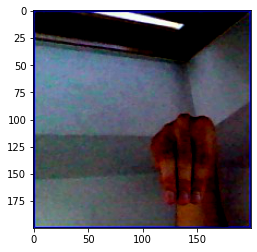

In [31]:
# Populate dataframe with (filename, label) pairs
df = build_dataframe(train_file_paths)

# Split dataset into training and testing data:
#    Pull a sample of size sample_fraction from the dataset.
#    Test set is test_size proportion of sample, training set is the rest.
train_df, test_df = train_test_split(df.sample(frac = sample_fraction), test_size=test_size, random_state=0)

# Create data generators and image sets.
train_generator,test_generator,train_images,val_images,test_images = generate_image_data()

# Confirm data shape
print('\nImage Shape:')
for images, labels in train_images:
    print(images.shape, labels.shape)
    plt.imshow(images[0])
    break

# Step 5: Build the Model

In [32]:
# Using a Sequential model to build a stacked layer neural network.
# Each layer has one input tensor and one output tensor.
model = tf.keras.models.Sequential([
  
  # INPUT LAYER
  # Flattens the multi-dimensional image array into a 1-dimensional vector
  tf.keras.layers.Flatten(input_shape=(input_shape[0],input_shape[1],3)),
  
  # HIDDEN LAYERS:
  # This layer implements the output = activation(dot(input,kernel)+bias).
  #    kernel: a weights matrix created by the layer.
  #    bias: a bias vector created by the layer.
    
  #tf.keras.layers.Dense(512, activation='relu'),

  tf.keras.layers.Dense(256, activation='relu'),

  tf.keras.layers.Dense(128, activation='relu'),

  # The dropout represents a threshold at which we eliminate some units at random. 
  # In the final hidden layer, this gives each unit a 50% chance of being eliminated
  # at every training step. Helps prevent overfitting.
  tf.keras.layers.Dropout(dropout),
  
  # OUTPUT LAYER: 
  # Apply softmax function here to satisfy loss function requirements.
  tf.keras.layers.Dense(29, activation='softmax')
])

# List model shape and parameters
model.summary()

# Adam: Adaptive Movement Estimation
# Optimizer: e.g. gradient descent. Determines direction and extent of change.
# Loss: estimates loss of system. Used when training the model.
# Metrics: Judges the performance of the model (others: probabilistic, regression, T/F)
# Metrics are not used when training the model.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 120000)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               30720256  
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 29)                3741      
Total params: 30,756,893
Trainable params: 30,756,893
Non-trainable params: 0
_________________________________________________________________


# Step 6: Train and Validate the Model

Epoch 1/50
1305/1305 [==============================] - 230s 176ms/step - loss: 5.0628 - accuracy: 0.0629 - val_loss: 3.0744 - val_accuracy: 0.1069
Epoch 2/50
1305/1305 [==============================] - 229s 175ms/step - loss: 3.0483 - accuracy: 0.1087 - val_loss: 2.8211 - val_accuracy: 0.1367
Epoch 3/50
1305/1305 [==============================] - 230s 176ms/step - loss: 2.9436 - accuracy: 0.1200 - val_loss: 2.8247 - val_accuracy: 0.1294
Epoch 4/50
1305/1305 [==============================] - 230s 176ms/step - loss: 2.9019 - accuracy: 0.1249 - val_loss: 2.7667 - val_accuracy: 0.1568
Epoch 5/50
1305/1305 [==============================] - 231s 177ms/step - loss: 2.8791 - accuracy: 0.1310 - val_loss: 2.7907 - val_accuracy: 0.1589
Epoch 6/50
1305/1305 [==============================] - 230s 176ms/step - loss: 2.8396 - accuracy: 0.1390 - val_loss: 2.5921 - val_accuracy: 0.1792
Epoch 7/50
1305/1305 [==============================] - 228s 175ms/step - loss: 2.7926 - accuracy: 0.1458 - val_

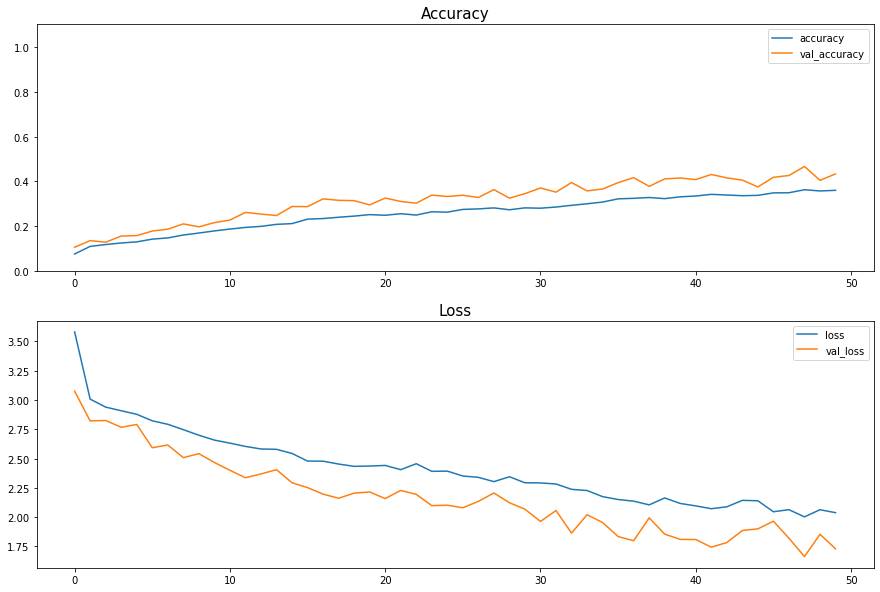

In [33]:
# Train the model without validation data
#history = model.fit(train_images, epochs=epochs)

# Train the model with validation data
fit_history = model.fit(train_images, validation_data=val_images, epochs=epochs)

# Plot accuracy and losses for training set and validation set
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(fit_history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(fit_history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

# Step 7: Evaluate the Model with Test Data

In [34]:
# Determine unbiased loss values and metrics for model using test data.
(loss, accuracy) = model.evaluate(test_images, verbose=1)
print(f'\nThe final model has prediction accuracy of {accuracy * 100:.2f}% and loss of {loss:.5f}.')

522/522 [==============================] - 38s 73ms/step - loss: 1.7524 - accuracy: 0.4339

The final model has prediction accuracy of 43.39% and loss of 1.75238.


# Step 8: Predict Test Image Labels

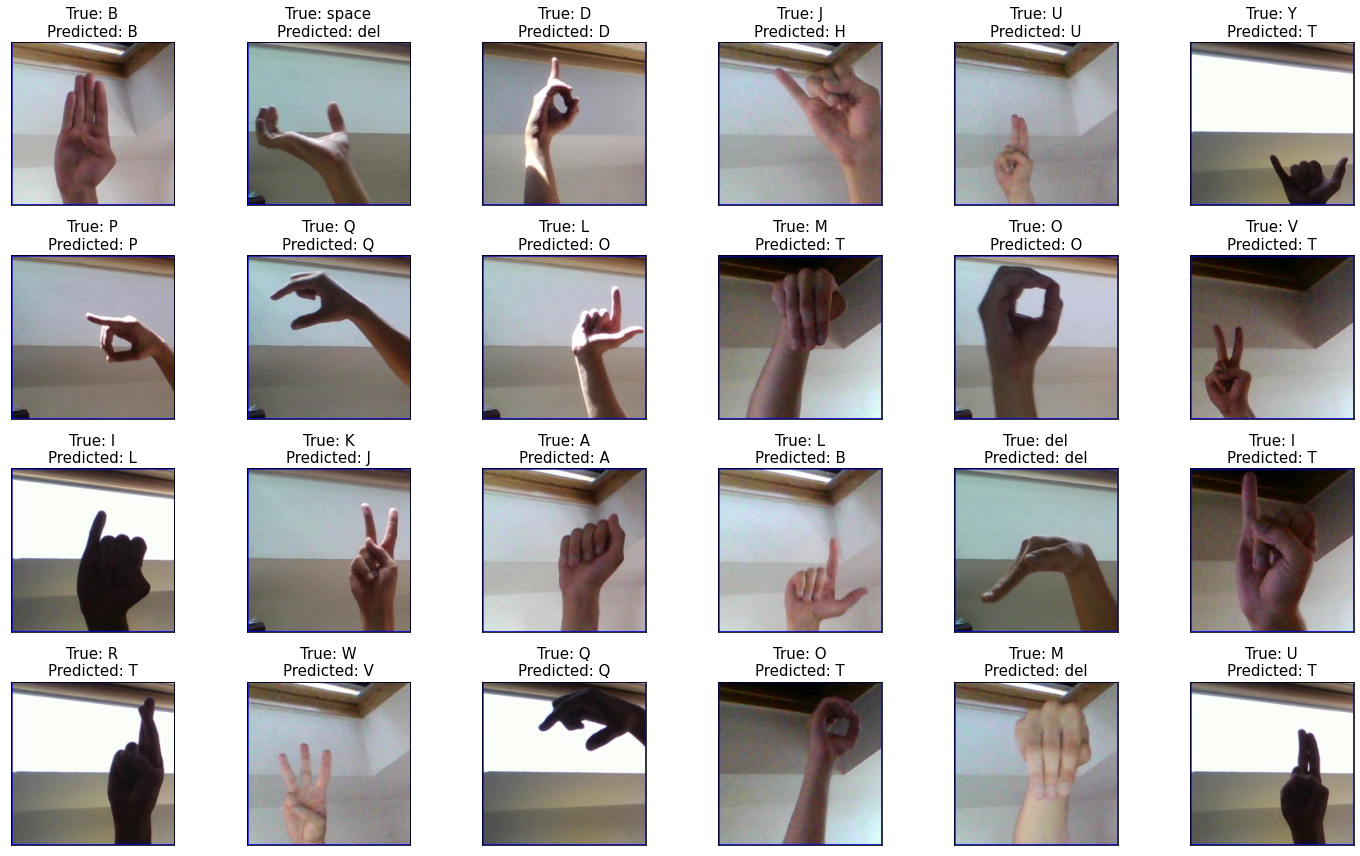

In [35]:
# Predict category for test images and convert to letter labels
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictions]

# Display sample of test images and predictions
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {predictions[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

# Step 9: Analysis of Predictions

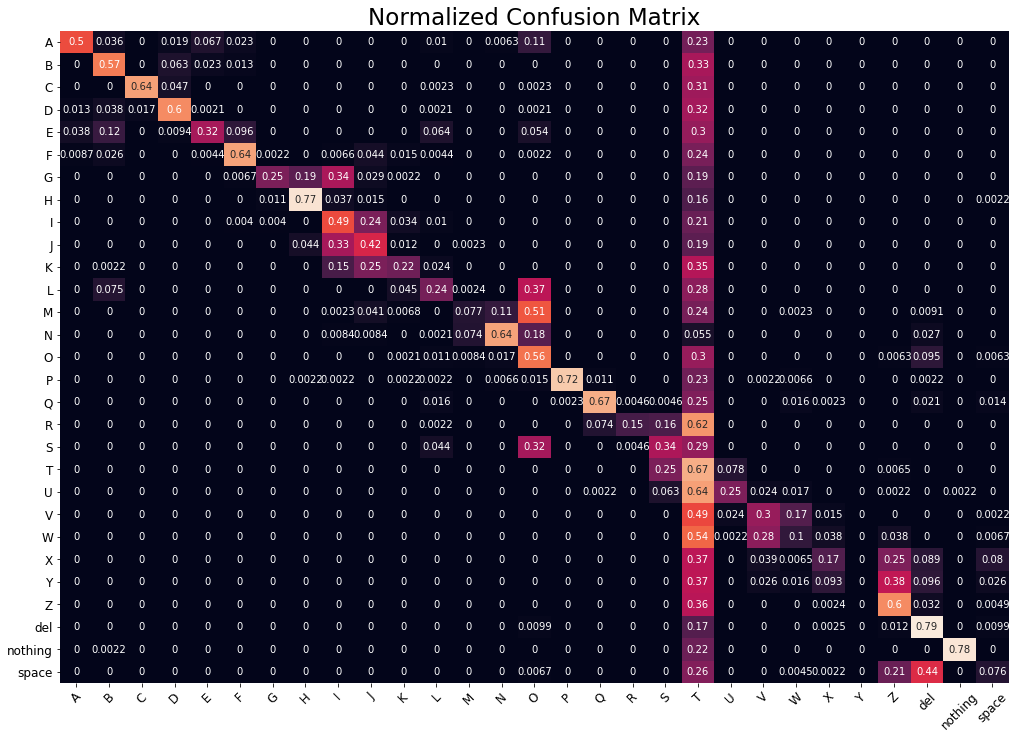

In [36]:
# Analysis: Confusion Matrix
#
#   Columns: predicted label
#      Rows: true label

y_test = list(test_df.Label)
cf_matrix = confusion_matrix(y_test, predictions, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

In [37]:
# Analysis: Classification Report
#
#   precision: the ability of the classifier not commit false positives
#   recall: proportion of correct predictions
#   f1-score: proportion of true positives compared to (true + false positives).
#   support: number of images per category
#   accuracy: 
#   macro avg: averaging unweighted mean per label
#   weighted avg: averaging the support-weighted mean per label

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           A       0.90      0.50      0.64       477
           B       0.67      0.57      0.62       474
           C       0.97      0.64      0.77       429
           D       0.82      0.60      0.69       469
           E       0.75      0.32      0.45       425
           F       0.82      0.64      0.72       458
           G       0.93      0.25      0.39       447
           H       0.77      0.77      0.77       459
           I       0.39      0.49      0.43       494
           J       0.38      0.42      0.40       431
           K       0.65      0.22      0.33       458
           L       0.54      0.24      0.33       425
           M       0.45      0.08      0.13       441
           N       0.83      0.64      0.72       474
           O       0.27      0.56      0.37       474
           P       1.00      0.72      0.84       457
           Q       0.88      0.67      0.76       433
           R       0.94    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Extras

    Image Total: 87000
 Category Total: 29
Images/Category: 3000
         Labels: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space'] 



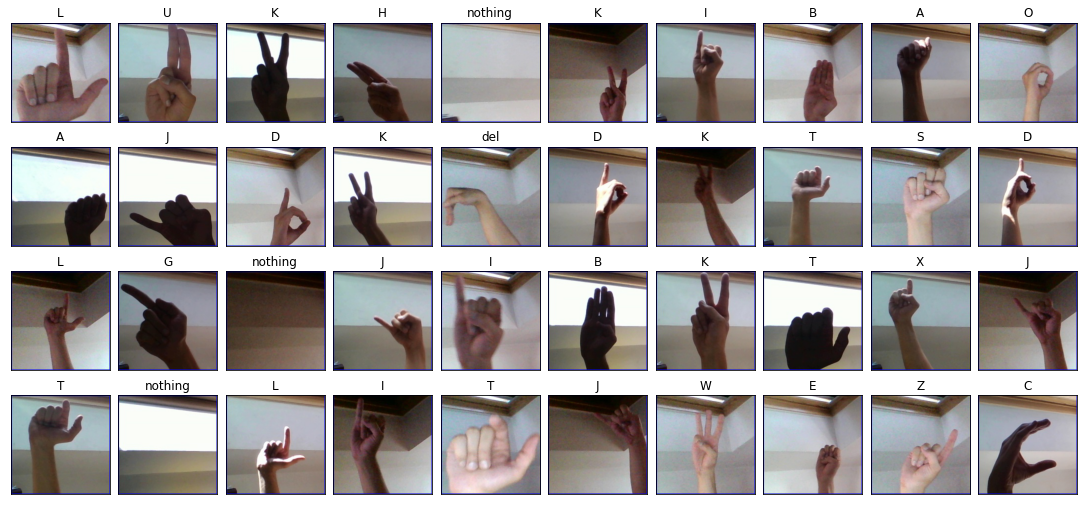

In [38]:
print(f'    Image Total: {df.shape[0]}')
print(f' Category Total: {len(df.Label.unique())}')
print(f'Images/Category: 3000')
print(f'         Labels: {sorted(df.Label.unique())} \n')

# Sample 40 images from dataset
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i])
plt.tight_layout(pad=.5)
plt.show()